In [3]:
import numpy as np
from toolz import pipe, compose
from math import isclose

from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
# https://www.unioviedo.es/compnum/labs/PYTHON/Interpolation.html
#http://balitsky.com/teaching/phys420/Nm1_interpolation.pdf

### Three Tabular  values (x1,x2,x3)

Interpoaltion from three tabulas values is permitted when the second differences are almost constant in the part of the table to be used, i.e., when the thrid differences are almost zero.

In [16]:
# Pag 24. Distance of Mars to the Earth from 5 to 9 November 1992,
# at Oh TD in astronomical units:
xs = np.array([5,6,7,8,9])  # days
ys = np.array([.898013,.891109,.884226, .877366, .870531]) # distance

In [17]:
print("Input array  : ", ys) 
print("First order difference  : ", np.diff(ys)) 
print("Second order difference : ", np.diff(ys, n = 2)) 
print("Third order difference  : ", np.diff(ys, n = 3))

Input array  :  [0.898013 0.891109 0.884226 0.877366 0.870531]
First order difference  :  [-0.006904 -0.006883 -0.00686  -0.006835]
Second order difference :  [2.1e-05 2.3e-05 2.5e-05]
Third order difference  :  [2.e-06 2.e-06]


The central value $x_{2}$ must be chosen in such a way that it is that value of x that is closest to the value of x for which we want to perform the interpolation. For example, to obtain the value for November 7 at 22h 14m, the $x_{2}$ = 8, so we would use the entries 7,8,9 i.e. we need 3 values to interpolate.

Interpolating factor n is x-$x_{2}$, n should be between -0.5 and 0.5 although the following formulae will also given correct: 
y = $y_{2}$ + n/2 (a+b+n*c)

In [18]:
#Pag 25
#Calculate the distance of Mars to the Earth on 1992 November 8, at 4h 21m

In [19]:
def hhmmss2hh(h,m,s):
    return h+(m/60)+(s/3600)


In [32]:
n = hhmmss2hh(4,21,0)/24 # the tabular interval is 24h
a,b = np.diff(ys[2:]) # first differences from 7 Nov
c = np.diff(ys[2:],2) # second differences from 7 Nov
c = c[0] # from array to scalar
y1,y2,y3 = ys[2:] # y's from 7 Nov
print ("Y: ",y2 + (n/2) * (a+b+n*c))

Y:  0.8761253012695313


If the tabulated function reaches an extremum (maximun or minimun), this can be found with the formulae:

ym = y2 - (np.square(a+b)/(8*c))

nm = - (a + b)/(2*c) in units of the tabular interval from the central value x2

In [80]:
# Calculate the time of passage of Mars through the perihelion  in May
# 1992 and the value of its radus vector at that instant. The 
# Sun-Mars distance have been calculated at intervasl of 4 days
xs = np.array([12.,16.,20.])  # days
ys = np.array([1.3814294, 1.3812213, 1.3812453]) # distance
x1,x2,x3 = xs
y1,y2,y3 = ys 
a,b = np.diff(ys) # first differences 
c = np.diff(ys,2) # second differences

ym = y2 - ((a+b)*(a+b)/(8*c))
nm = - (a + b)/(2*c) 
print (f'X min:{x2+nm}, Y min:{ym}, N min:{nm}') 


X min:[16.39659629], Y min:[1.38120305], N min:[0.39659629]


In [89]:
# Using  general interporlation
f_linear = interp1d(xs,ys,'slinear') # the interpolation function
xsg = np.linspace(12.,20.,6) # a grid for the x
ysg = f_linear(xsg) # Obtain the y's evaluated in the grid
y_min = np.min(ysg)
x_min = xsg[np.argmin(ysg)]
print (f'X min:{x_min}, Y min:{y_min}') 


X min:16.8, Y min:1.3812261


The value of the argument x for which the function y becomes zero can be found by:
n0 = -2*y2/(a+b+c*n0)
This equation can be solved by first putting n=0 in the second member and doing interations until n0 does not varies between two iterations.


In [21]:
def f_n0 (y2,a,b,c,n0):
    return -2*y2/(a+b+c*n0)
def resolve_n0(y2,a,b,c):
    n0 = 0
    for x in range(100):
        new_n0 = f_n0(y2,a,b,c,n0)
        print (new_n0) 
        if np.isclose(new_n0,n0):
            print ("Converged")
            return new_n0
        n0 = new_n0
    print ("NOT converged")
    return new_n0
    
        

In [30]:
def ddmmss2seg(dg,arm=0,ars=0,sign="+"):
    value = dg*3600 + arm*60 + ars
    return value if sign=="+" else -value 

def decimaldays2dayhhmmss(ddays):
    dhours,days = np.modf(ddays)
    dminutes, hours = np.modf(dhours*24)
    dseconds, minutes = np.modf(dminutes*60)
    return f'Day:{int(days)} at {int(hours)}h {int(minutes)}m {int(dseconds)}s'

    

In [145]:
# Pag 26 Given the following values for the declination of Mercury,
# calculate when the planet's declination is zero.
# We pass all the quantities to seconds for doing the differences
xs = np.array([26.,27.,28.])  # days
x1,x2,x3 = xs
y1 = ddmmss2seg(0,28,13.4,"-")
y2 = ddmmss2seg(0,6,46.3)
y3 = ddmmss2seg(0,38,23.2)
ys = np.array([y1,y2,y3]) # declinations
a,b = np.diff(ys) # first differences 
c = np.diff(ys,2) # second differences
n= resolve_n0(y2,a,b,c)[0] # n is the delta with respect x2
print (f'Declination is 0 for {decimaldays2dayhhmmss(x2+n)}')



Converged
Declination is 0 for Day:26 at 19h 10m 0s


The problem with the above approach is that only works with the function does not have much curvature. If that is the case the following formulae is better:

n0 = -(2*y2+n0(a+b+c*n0)/(a+b+2*c*n0)

In [26]:
def f2_n0 (y2,a,b,c,n0):
    return -(2*y2+(n0*(a+b+c*n0)))/(a+b+2*c*n0)

def resolve2_n0(y2,a,b,c):
    n0 = 0
    for x in range(10):
        new_n0 = f2_n0(y2,a,b,c,n0)
        print (new_n0) 
        if np.isclose(new_n0,n0):
            print ("Converged")
            return new_n0
        n0 = new_n0
    print ("NOT converged")
    return new_n0
    

In [27]:
xs = np.array([-1.,0.,1.])  # days
x1,x2,x3 = xs
y1 = -2.
y2 = 3.
y3 = 2.
ys = np.array([y1,y2,y3]) # declinations
a,b = np.diff(ys) # first differences 
c = np.diff(ys,2) # second differences
n= resolve2_n0(y2,a,b,c)[0] # n is the delta with respect x2
print (n)


[-1.5]
[0.61363636]
[1.84183047]
[-0.38596444]
[-0.41270935]
[-0.37164859]
[-0.43555131]
[-0.33810503]
[-0.49169193]
[-0.26086743]
NOT converged
-0.2608674257484742


### Five Tabular  values (x1,x2,x3,x4,x5)

When the third differences may not be neglected, more than three values must be used. Use 5 five values and follows the same procedure as before but with different formulae

In [33]:
# See the formules at pag 28
xs = np.array([27.,27.5,28.,28.5,29])
y1 = ddmmss2seg(0,54,36.125)
y2 = ddmmss2seg(0,54,24.606)
y3 = ddmmss2seg(0,54,15.486)
y4 = ddmmss2seg(0,54,08.694)
y5 = ddmmss2seg(0,54,04.133)
ys = np.array([y1,y2,y3,y4,y5])

print("First order difference  : ", np.diff(ys)) 
print("Second order difference : ", np.diff(ys, n = 2)) 
print("Third order difference  : ", np.diff(ys, n = 3))
print("Fourth order difference  : ", np.diff(ys, n = 4))


First order difference  :  [-11.519  -9.12   -6.792  -4.561]
Second order difference :  [2.399 2.328 2.231]
Third order difference  :  [-0.071 -0.097]
Fourth order difference  :  [-0.026]


The third differences may not be neglected unless an accuracy of 0".1 is suficcient.

When interpolating times and right ascensions it is important to remark they hum to zero when the value of 24 hours is reached. For this purpose, it may be needed to transfomr 0h 01m 00.71 to 24h 01m and so on.

As much as possible, avoid making and interpolation for |n| > 0.5 

### Interpolation with unequally-spaced abcissae (Lagrange's interpolation formula)


In [68]:
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

xs = np.deg2rad(np.array([29.43, 30.97,27.69,28.11,31.58,33.05]))
ys = np.sin(xs) #
poly = lagrange(xs, ys)
print ("Sin (0) :",poly(np.deg2rad(0)))
print ("Sin (90) :",poly(np.deg2rad(90)))



Sin (0) : 1.264079037355259e-05
Sin (90) : 1.0011157543544058


In [52]:
ys

array([0.46468751, 0.47116583, 0.49135985, 0.51458919, 0.52368857,
       0.54537071])

Text(0, 0.5, 'Y')

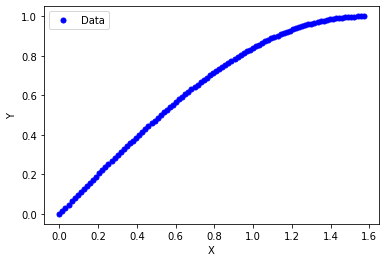

In [64]:
# plot results to illustrate
xsg = np.deg2rad(np.linspace(0.,90,100))
ysg = poly(xsg)
pl.ion()
pl.plot(xsg,ysg,'bo',markersize=5)
#pl.plot(xs,ys,'g')
pl.legend(['Data','Linear','Exact'],loc='best')
pl.xlabel('X')
pl.ylabel('Y')

#### Using general interpolation function

In [31]:
import matplotlib.pyplot as pl

from scipy.interpolate import interp1d

# linearly interpolate
x = np.linspace(0.,10.,201)
x = np.array([8.18125])

# linearly interpolate
linear = interp1d(xs,ys,'linear')
slinear = interp1d(xs,ys,'quadratic')
#Specifies the kind of interpolation as a string (‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, ‘next’, where ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of zeroth, first, second or third order; ‘previous’ and ‘next’ simply return the previous or next value of the point) 
# apply and create new array
y_linear = linear(x)
y_slinear = slinear(x)

Text(0, 0.5, 'Y')

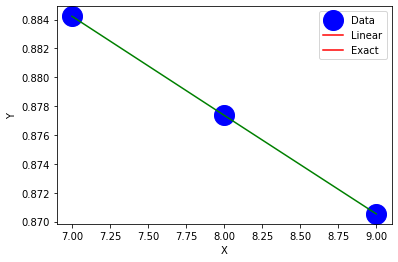

In [32]:
# plot results to illustrate
pl.ion()
pl.plot(xs,ys,'bo',markersize=20)
pl.plot(x,y_linear,'r')
pl.plot(x,y_slinear,'r')
pl.plot(xs,ys,'g')
pl.legend(['Data','Linear','Exact'],loc='best')
pl.xlabel('X')
pl.ylabel('Y')

In [34]:
# Distance Sun - Mars in UA for 4 days intervals
xs = np.array([12.,16.,20.])
ys = np.array([1.3814294,1.3812213,1.3812453])

Text(0, 0.5, 'Y')

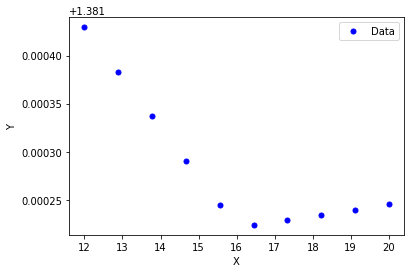

In [88]:
# plot results to illustrate
pl.ion()
pl.plot(xsg,ysg,'bo',markersize=5)
#pl.plot(xs,ys,'g')
pl.legend(['Data','Linear','Exact'],loc='best')
pl.xlabel('X')
pl.ylabel('Y')